# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

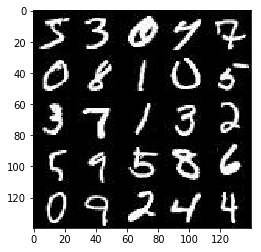

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

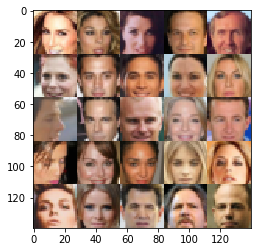

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)) 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), 0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.dropout(tf.maximum(alpha * bn2, bn2), 0.8)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.dropout(tf.maximum(alpha * bn3, bn3), 0.8)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=False if is_train else True):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(logits.shape)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # generator output range [-1, 1] while real image [-0.5, 0.5], need rescale
                batch_images = batch_images * 2
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 9, inputs_z, data_shape[3], data_image_mode)
    return losses


### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 6.4082
Epoch 1/2... Discriminator Loss: 0.4253... Generator Loss: 4.2380
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 2.2019
Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 0.7073... Generator Loss: 2.8931
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 4.3893
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.2702
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 0.7046... Generator Loss: 2.8483


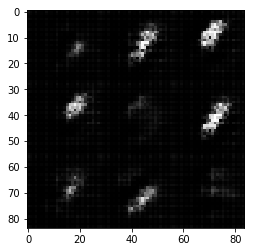

Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 2.3967
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 2.3900
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 2.4531
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 1.8245
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.0893
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 2.0322
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 1.3121


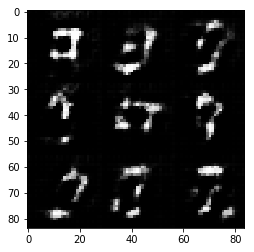

Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.6996
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.8318
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 1.1564
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.7904
Epoch 1/2... Discriminator Loss: 1.6067... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 1.3609


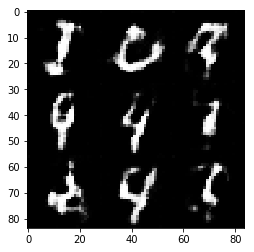

Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 1.6530... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 1.2369
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 1.5623
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.2909
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.0479
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.5328


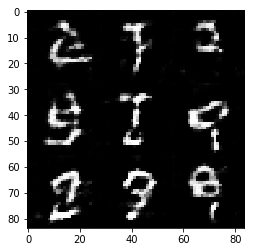

Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.3904
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.8957
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.0922


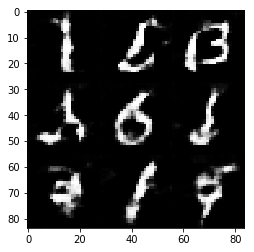

Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 1.7982
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.8812


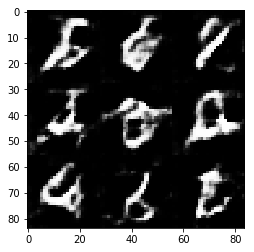

Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.9022
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 1.4538
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.8457


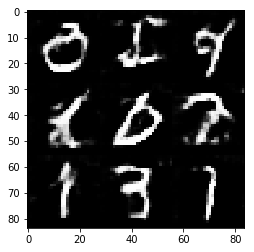

Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.2845
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.9788


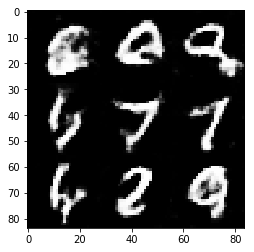

Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 1.4269
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 1.0350
Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 1.1786
Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.7506... Generator Loss: 2.1015
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.8696


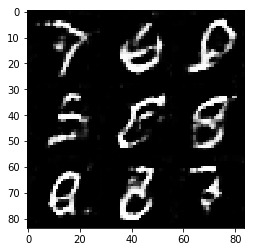

Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.3910
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.6319... Generator Loss: 1.9533
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 1.4837


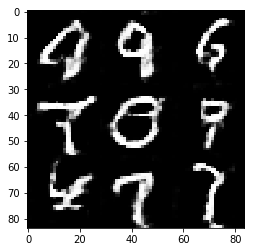

Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 1.5168
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.8934
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 1.2162
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 0.9313


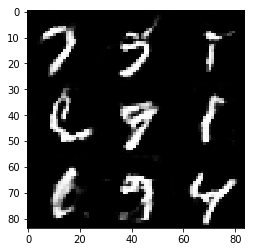

Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 1.5441
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 1.5839
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.7271


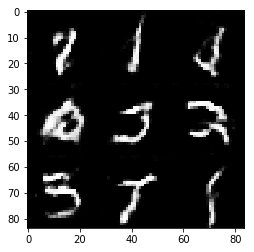

Epoch 2/2... Discriminator Loss: 2.4725... Generator Loss: 3.2572
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.5586... Generator Loss: 2.3265
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 1.7626
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.4913... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.3018
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 2.6271


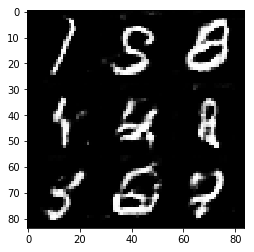

Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 1.8044... Generator Loss: 2.1406
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 1.6265... Generator Loss: 0.4892
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 1.5991
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 1.3947


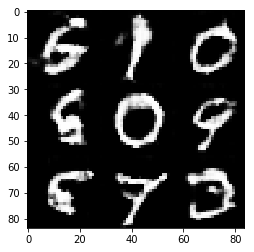

Epoch 2/2... Discriminator Loss: 1.9951... Generator Loss: 0.3138
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.0290
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 1.1600
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 2.0070... Generator Loss: 3.2693


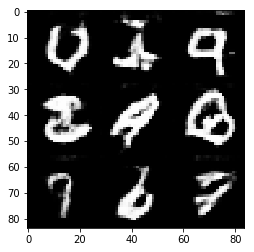

Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 1.1708
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 1.1873... Generator Loss: 1.3598
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 1.0211


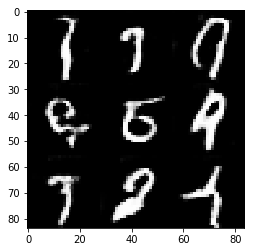

Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 2.0008
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 1.2627
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.3249
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 1.3131


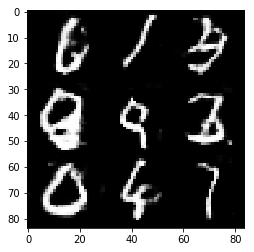

Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 1.4934
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 1.7706
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.8821
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 1.3929
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.7271


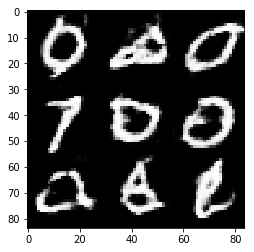

Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 1.3511
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.1151
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.2705
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.2188
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 0.9263


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 6.1011
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 3.7057
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 11.3829
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 5.7274
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 3.5619
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 4.0419
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.6864
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.7232


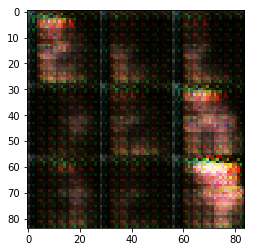

Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.9426
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 3.2114
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.9854... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 2.8269
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.9857


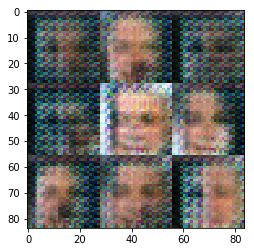

Epoch 1/1... Discriminator Loss: 1.6314... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.7875
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.8187
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8306


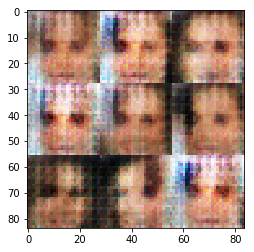

Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.4643
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 2.1820
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.3481


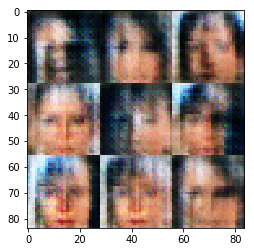

Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.3034
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.9013... Generator Loss: 3.1994
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.7484
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.5104
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 2.1381
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.7745
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7268


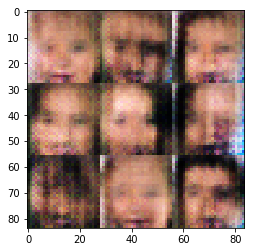

Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.8856
Epoch 1/1... Discriminator Loss: 1.7143... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 2.1002... Generator Loss: 0.4119
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.9339
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.7145
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7468


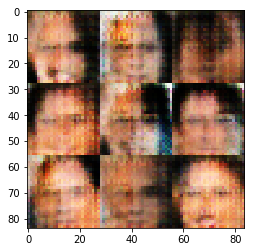

Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 1.1328


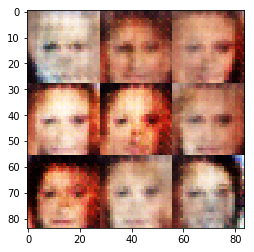

Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7378


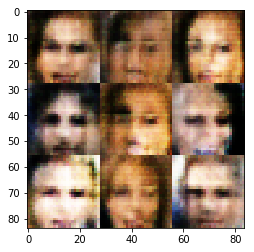

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.2564
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.1463
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.7519


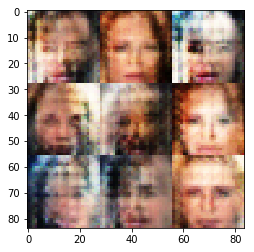

Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.0524


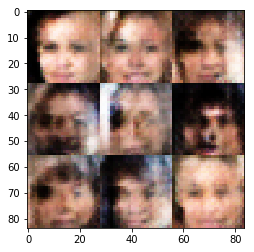

Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7969


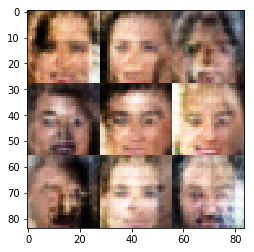

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.0540


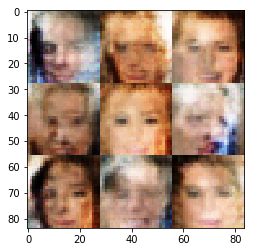

Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.4080
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.4487
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.0177


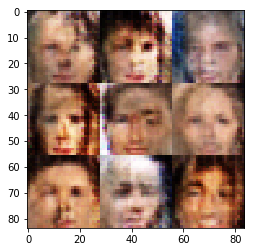

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9280


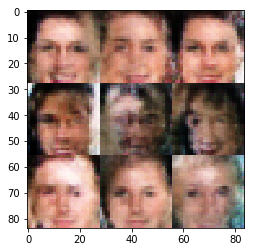

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 1.6112
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9527


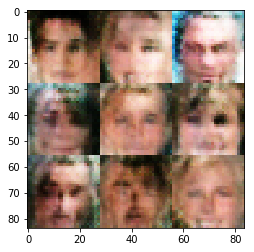

Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9836


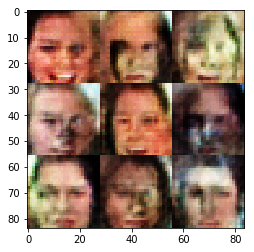

Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9823


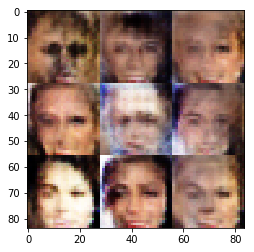

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.1508


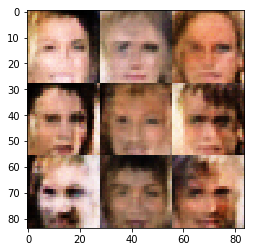

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.4550
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.1008


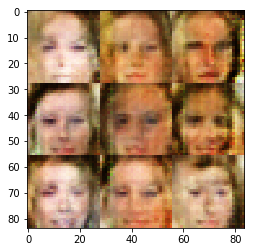

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 1.5370
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.2189


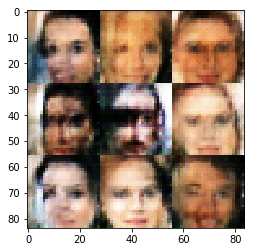

Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6973


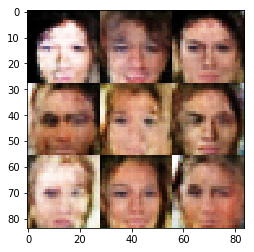

Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.4170
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0203


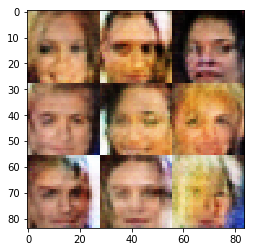

Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.1078


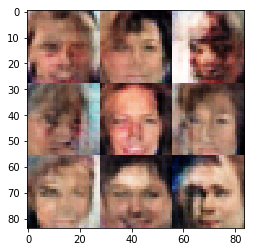

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.5207


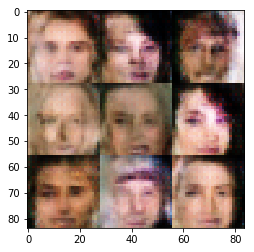

Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.7115


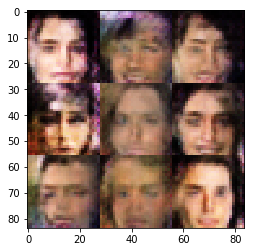

Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7464


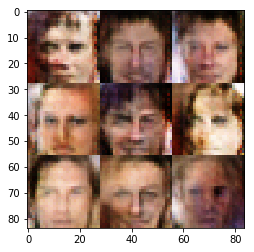

Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.8358... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.5068


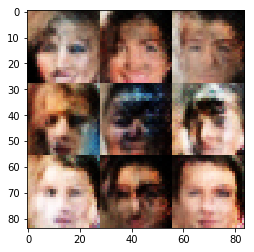

Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.1035


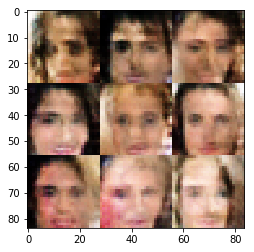

Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.1118


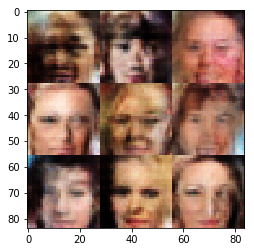

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.8165


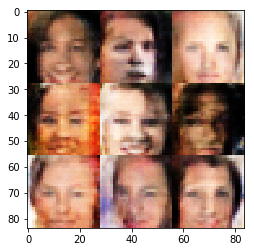

Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9568


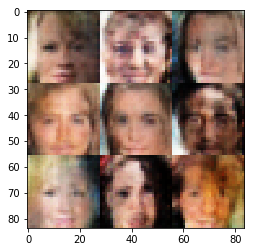

Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6436


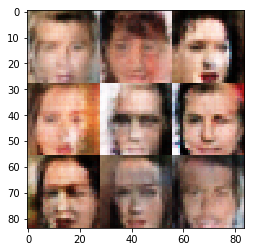

Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8924


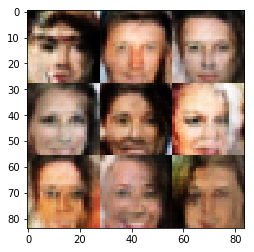

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9615


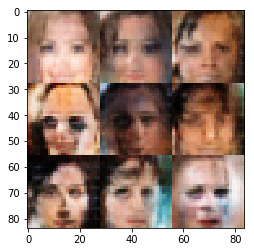

Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7293


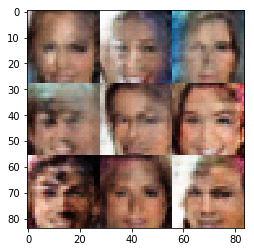

Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.2040


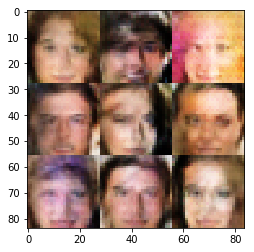

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8675


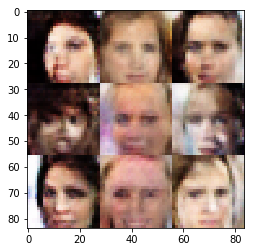

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.2410


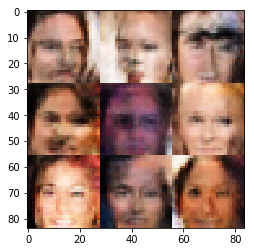

Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9338


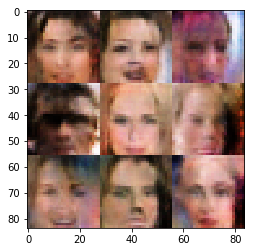

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0321


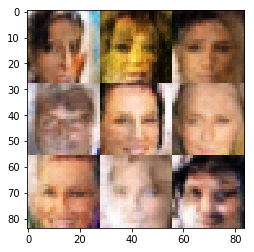

Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7698


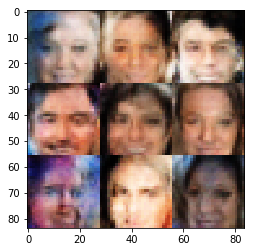

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 1.1552
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.0153


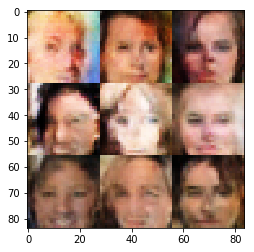

Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8126


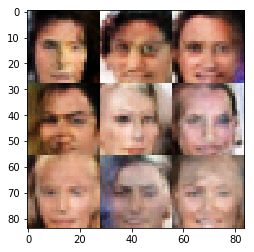

Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8597


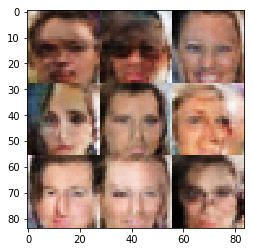

Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9501


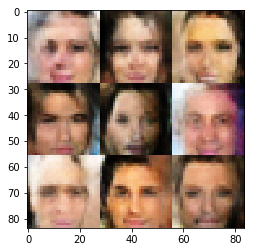

Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.3171


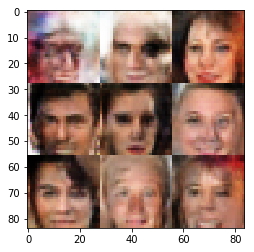

Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8752


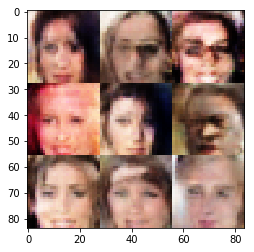

Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8853


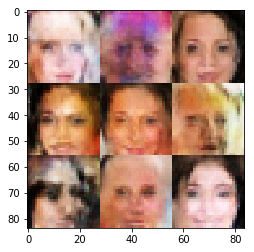

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7615


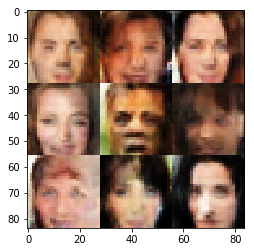

Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6641


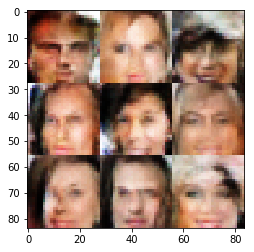

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 1.0874


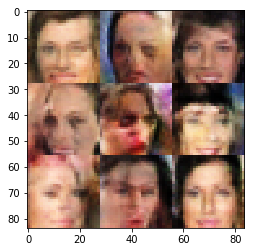

Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.0506


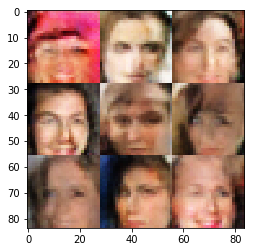

Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.0867


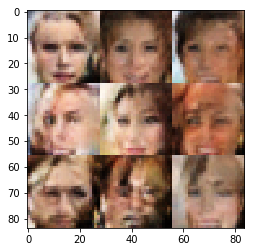

Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9770


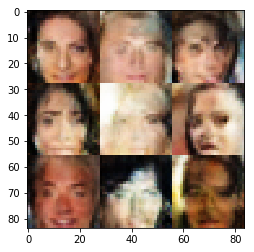

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8839


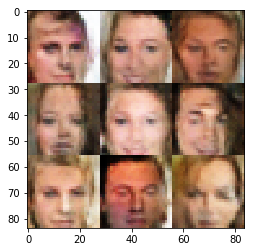

Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.9949


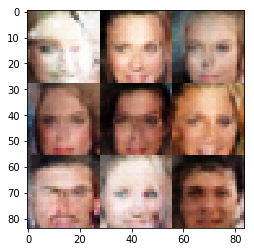

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9833


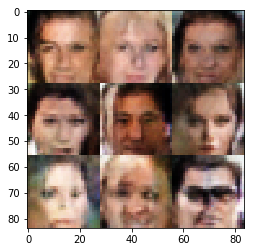

Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.9945


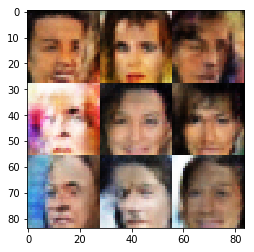

Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7870


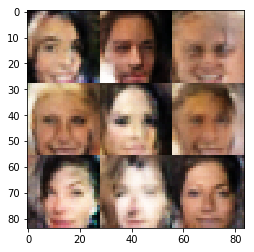

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.2760
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7139


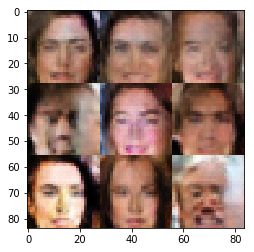

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7310


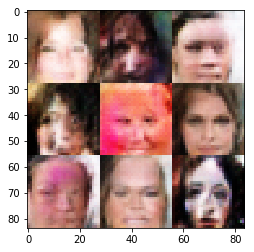

Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9777


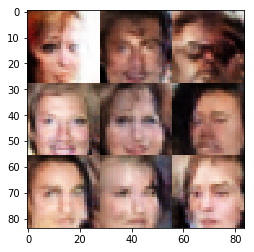

Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8286


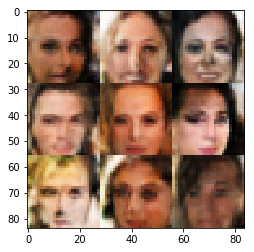

Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8371


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。